
<center><font size = "10"> Week 12 - Network Simulation II<center>
<center><font size = "8">Tutorial 02: Spike train analysis 02 <center>

<font size='3'><font color='blue'> In this tutorial we will analyze the spike trains from the different cells.
    
<font size='3'><font color='blue'> We will stimulate each cell with a __poisson__ spiketrain.
    
<font size='3'><font color='blue'>Then we will compute statistics on each spike train and we will compute a crosscorrelation analysis between spike trains using [ELEPHANT](https://elephant.readthedocs.io/en/latest/index.html), a library for the analysis of electrophysiological data in Python.

### Compile the MOD files necesary for the simulation

In [1]:
!nrnivmodl

/opt/jlab-env/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/NX450/Tutorial_12-20241201
Mod files: "./vecevent.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


### Load useful packages

In [2]:
# Load useful packages
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np

# Load external files & initialize
h.load_file("stdrun.hoc")
h.stdinit()

--No graphics will be displayed.


0.0

### Define the class Cell

In [13]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()

    def build_morphology(self, filename):
        h.load_file("import3d.hoc")
        h.load_file("stdlib.hoc")
        # morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(
            self
        )  # Notice this change to be able to instantiate several cells

    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75

        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        if hasattr(self, "apic"):
            for sec in self.apic:
                sec.insert("hh")
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        for sec in self.dend:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        for sec in self.axon:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

### Load the morphologies to work with

<font size='3'> Running the next cell will result in an error message due to the morphology file, but don't pay attention to it, you will be able to run the simulations on these morphologies

In [14]:
Pyr1 = Cell("Pyr_01.swc", "Pyr1", "Pyr")
Pyr2 = Cell("Pyr_02.swc", "Pyr2", "Pyr")
Int1 = Cell("Int_01.swc", "Int1", "Int")
cells_Pyr = [Pyr1, Pyr2]
cells_Int = [Int1]
cells = cells_Pyr + cells_Int

### Check the number of sections

In [15]:
for c in cells_Pyr:
    print(
        "%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions"
        % (c.name, len(c.apic), len(c.dend), len(c.soma), len(c.axon))
    )
for c in cells_Int:
    print(
        "%s: %d basal sections, %d soma sections and %d axon senctions"
        % (c.name, len(c.dend), len(c.soma), len(c.axon))
    )

Pyr1: 29 apical sections, 38 basal sections, 1 soma sections and 217 axon senctions
Pyr2: 45 apical sections, 52 basal sections, 1 soma sections and 157 axon senctions
Int1: 53 basal sections, 1 soma sections and 157 axon senctions


### Connect cells

In [16]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(
    source,
    target,
    weight=None,
    delay=5,
    source_sec=None,
    source_neurite="axon",
    target_sec=None,
    target_neurite="dend",
    rng=None,
    seed=None,
):
    if rng is None:
        rng = np.random.default_rng(seed)

    if weight is None:
        weight = rng.uniform()  # random weight

    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0, len(target_neurite_))  # random dendritic section

    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0, len(source_neurite_))  # random axonal section

    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn)  # store synapse

    netcon = h.NetCon(
        source_neurite_[source_sec](0.5)._ref_v,
        target_syn,
        sec=source_neurite_[source_sec],
    )
    netcon.weight[0] = weight
    netcon.delay = delay

    print(
        "Connected cells %s::%s[%d] -> %s::%s[%d] with weight %g and delay %g"
        % (
            source.name,
            source_neurite,
            source_sec,
            target.name,
            target_neurite,
            target_sec,
            weight,
            delay,
        )
    )
    return netcon

In [17]:
netcons = []  # save the netcons in case we want to modify them later

seed = 1234  # specify seed for replicability of all that follows
rng = np.random.default_rng(seed)

# Connect Pyr2 and Int1 to Pyr1
nc = connect(Pyr2, Pyr1, rng=rng, weight=0.1)
netcons.append(nc)
nc = connect(Int1, Pyr1, rng=rng, weight=0.1, target_neurite="soma")
netcons.append(nc)

# Connect Pyr1 and Int1 to Pyr2
nc = connect(Pyr1, Pyr2, rng=rng, weight=0.1)
netcons.append(nc)
nc = connect(Int1, Pyr2, rng=rng, weight=0.1, target_neurite="soma")
netcons.append(nc)

# Connect Pyr1 and Pyr2 to Int1
nc = connect(Pyr1, Int1, rng=rng, weight=0.1)
netcons.append(nc)
nc = connect(Pyr2, Int1, rng=rng, weight=0.1)
netcons.append(nc)

Connected cells Pyr2::axon[153] -> Pyr1::dend[37] with weight 0.1 and delay 5
Connected cells Int1::axon[155] -> Pyr1::soma[0] with weight 0.1 and delay 5
Connected cells Pyr1::axon[37] -> Pyr2::dend[19] with weight 0.1 and delay 5
Connected cells Int1::axon[144] -> Pyr2::soma[0] with weight 0.1 and delay 5
Connected cells Pyr1::axon[56] -> Int1::dend[5] with weight 0.1 and delay 5
Connected cells Pyr2::axon[50] -> Int1::dend[7] with weight 0.1 and delay 5


### Add synapses

In [18]:
# Place exponential synapses in random cell sections

# Exponential synapses
synapses = []
for cell in cells:
    sec = rng.integers(0, len(cell.dend))
    syn = h.ExpSyn(cell.dend[sec](0.5))
    syn.tau = 2  # ms
    print(
        "ExpSyn created at %s::%s[%s] with tau = %g" % (cell.name, "dend", sec, syn.tau)
    )
    synapses.append(syn)

ExpSyn created at Pyr1::dend[20] with tau = 2
ExpSyn created at Pyr2::dend[6] with tau = 2
ExpSyn created at Int1::dend[42] with tau = 2


### Setup stimulator per cell

In [19]:
# Create stimulators for synapses
stims = []
stim_nc = []
for syn in synapses:
    stim = h.VecStim()
    nc = h.NetCon(stim, syn)
    nc.weight[0] = 0.5  # In units of [nS] due to the gmax scaling factor in our .mod file
    stims.append(stim)
    stim_nc.append(nc)

### Setup stimulation times: Poissonian

In [37]:
import elephant.spike_train_generation as elstg
import quantities as pq

# Create a Poissonian spike train
stim_rate = 60 * pq.Hz
stim_tstart = 5 * pq.ms
stim_tstop = 300 * pq.ms

stim_times = []
for stim in stims:
    sptimes = elstg.homogeneous_poisson_process(
        stim_rate, stim_tstart, stim_tstop, as_array=True
    )
    spvec = h.Vector(sptimes)
    stim.play(spvec)  # make stimulator fire at these times
    stim_times.append(sptimes)
    print(sptimes)

[  6.1392247   75.383043    83.78692403  96.50938048 119.64985309
 130.87652495 136.34689344 161.84702319 204.45278164 221.30007784
 245.15702606 256.56308501 258.63031009 259.99271808 267.99482847
 275.340019   288.50070635]
[ 18.39311215  20.93642667  30.3720977   35.59961659  52.31044778
 105.09754703 135.94372092 158.8528079  169.14195828 186.47185688
 206.16347325 212.33838299 239.4357552  252.52809908 254.12584104
 266.70020726 267.39797631 278.03823624 279.32026331 282.35158216
 285.32103786 287.74287488 297.75201713]
[ 29.15004532  32.12913357  62.80610132  65.02143604  76.9781246
 119.31674795 173.06129217 173.52672852 181.89195788 193.97827688
 202.239086   208.40557483 245.90916672 266.5681007  279.41880774
 287.08849381 297.28664568]


### Run simulation

In [38]:
recording_cells = [Pyr1, Pyr2, Int1]

somaV = []
for cell in recording_cells:
    s = h.Vector().record(cell.soma[0](0.5)._ref_v)
    somaV.append(s)

time = h.Vector().record(h._ref_t)
sim_tstop = 300

h.finitialize(-65)
h.continuerun(sim_tstop)

0.0

### Plot voltage traces

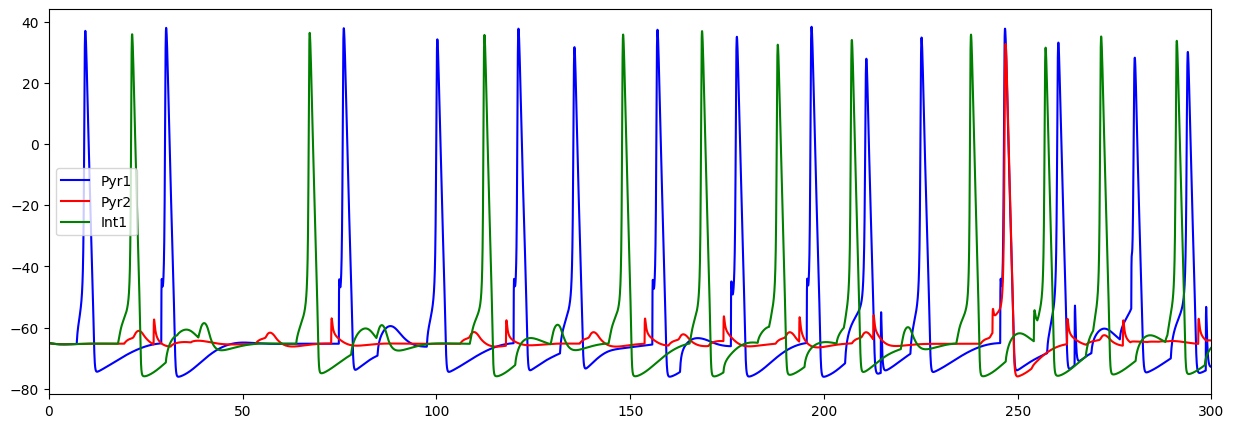

In [39]:
colors = ["blue", "red", "green"]

fig, ax = plt.subplots(figsize=(15, 5))
for cell, V, color in zip(recording_cells, somaV, colors):
    ax.plot(time, V, label=cell.name, color=color)

ax.set_xlim((0, sim_tstop))
ax.legend()
plt.show()

### Spike detection

In [40]:
from neo import AnalogSignal


def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to neo.AnalogSignal
    sig = AnalogSignal(
        voltage, units=pq.mV, sampling_period=0.025 * pq.ms
    )  # dt = 0.025 ms
    # peak locations
    spike_time = elstg.peak_detection(sig, threshold=threshold * pq.mV)
    
    return spike_time * 1000  # in ms

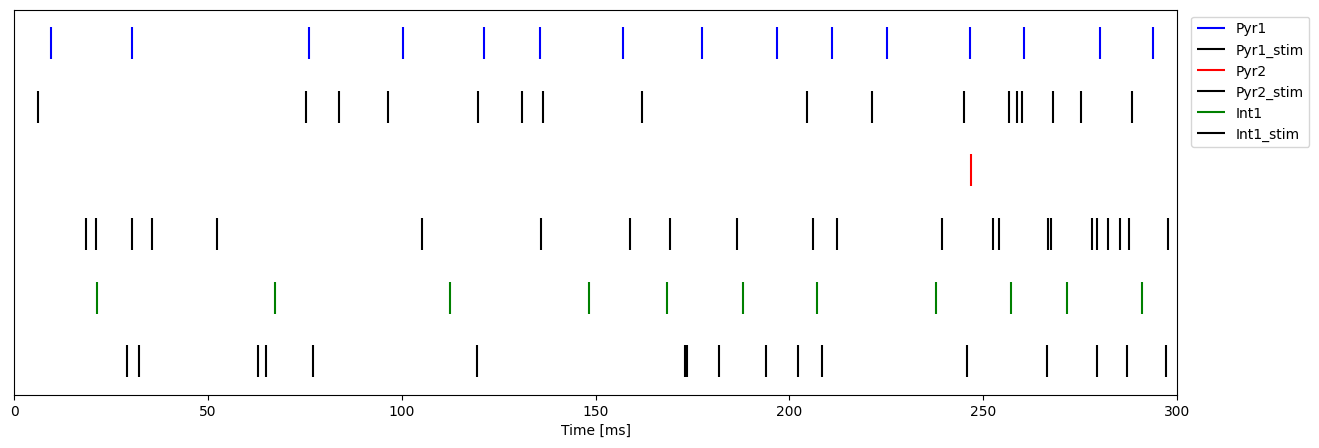

In [41]:
spike_trains = []
for V, st in zip(somaV, stim_times):
    spk = spike_detector(V, -20.0)  # tune threshold as needed
    spike_trains.append(spk)  # add cell spikes
    spike_trains.append(st)  # add stim spikes

name_lst = [[_.name, _.name + "_stim"] for _ in recording_cells]
name_lst = [x for sub in name_lst for x in sub]  # https://stackoverflow.com/a/952952

colors = ["blue", "black", "red", "black", "green", "black"]

fig, ax = plt.subplots(figsize=(15, 5))
for (i, name), spikes, color in zip(enumerate(name_lst), spike_trains, colors):
    ymin = 2 * i * -0.1
    ymax = 2 * i * -0.1 - 0.1
    ax.vlines(spikes, ymin=ymin, ymax=ymax, color=color, label=name)

ax.set_xlim((0, sim_tstop))
ax.set_xlabel("Time [ms]")
ax.set_yticks([])

# Put a legend below current axis
ax.legend(bbox_to_anchor=(1.12, 1))

plt.show()

## 1. Single Spike train statistics

In [42]:
import elephant.statistics as elstat


for x, spike_train in zip(name_lst, spike_trains):
    print(x)
    
    fr = (len(spike_train) / sim_tstop) * 1000
    
    print("Mean firing rate = %g Hz" % fr)
    # Inter-spike intervals
    isi = elstat.isi(spike_train)
    cv = elstat.cv(isi)
    print("CV of ISI = %g\n" % cv)

Pyr1
Mean firing rate = 50 Hz
CV of ISI = 0.387078

Pyr1_stim
Mean firing rate = 56.6667 Hz
CV of ISI = 0.94835

Pyr2
Mean firing rate = 3.33333 Hz
CV of ISI = nan

Pyr2_stim
Mean firing rate = 76.6667 Hz
CV of ISI = 0.957962

Int1
Mean firing rate = 36.6667 Hz
CV of ISI = 0.408317

Int1_stim
Mean firing rate = 56.6667 Hz
CV of ISI = 0.915846



/tmp/ipykernel_634/2307336416.py:12: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  cv = elstat.cv(isi)


## 2. Correlation analysis between spike trains

Cross-correlation is a measure of the similarity of the responses of two time series (in this case, spike trains) with various time offsets.
It can be used to visualize temporal dependencies between neurons and is sometimes used in experimental work (especially extracellular elecrophysiology) as a proxy for connectivity.
The logic of this proxy being that if the activity of one neuron is usually followed by the activity of another, it is likely that they are connected.

To compute it, elephant breaks the spike train down into equal length timesteps and averages firing statistics within each step.

*Note: If Pyr2 did not spike, there will be no correlations with Pyr2 in the next section, and there may be some errors!*

In [43]:
from neo import SpikeTrain
from elephant.conversion import BinnedSpikeTrain
import elephant.spike_train_correlation as elstc

### Pairwise correlation histograms

[<SpikeTrain(array([ 14.   ,  34.875,  54.8  ,  76.075,  90.225, 105.825, 125.525,
       151.275, 168.275, 189.925, 210.275, 228.25 , 246.125, 266.475,
       279.75 , 299.775]) * s, [None, None])>, <SpikeTrain(array([107.45]) * s, [None, None])>, <SpikeTrain(array([ 26.075,  46.375,  68.075,  98.3  , 116.25 , 163.425, 181.725,
       201.55 , 219.75 , 236.9  , 257.775, 290.925]) * s, [None, None])>]


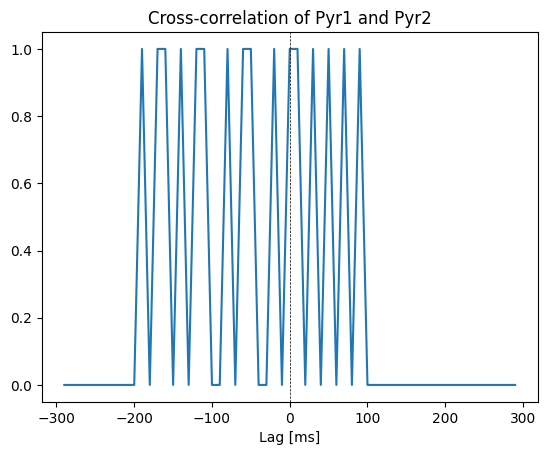

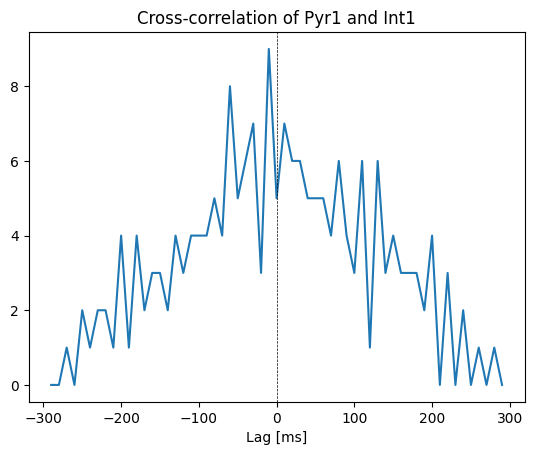

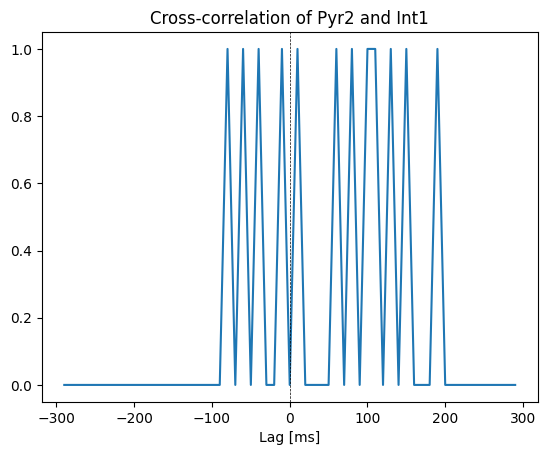

In [23]:
import itertools

# Pick only cell spike trains (saved in even entries of spike_trains)
cell_names = [x for i, x in enumerate(name_lst) if i % 2 == 0]
cell_spikes = [x for i, x in enumerate(spike_trains) if i % 2 == 0]

print(cell_spikes)

binsize = 10 * pq.ms  # 10 ms bin
cell_spikes = [SpikeTrain(x/1000, t_stop=sim_tstop * pq.ms) for x in cell_spikes]
#print(allspikes)
binned_spikes = [BinnedSpikeTrain(x, bin_size=binsize) for x in cell_spikes]
#print(binned_spikes)

for a, b in itertools.combinations(zip(cell_names, binned_spikes), 2):
    cch, lags = elstc.cross_correlation_histogram(a[1], b[1], border_correction=False)
    fig, ax = plt.subplots()
    ax.set_title("Cross-correlation of {} and {}".format(a[0], b[0]))
    ax.set_xlabel("Lag [ms]")
    plt.plot(lags * binsize, cch)
    plt.axvline(0, ls="--", color="black", lw=0.5)

### Pairwise correlation coefficients

A pairwise correlation coefficent measures the overall correlation between the responses of pairs of neurons throughout the simulation.
For instance, you may present a series of images to a model of a visual region and analyze how well the image-to-image variation in firing rate correlates between different neurons.
One example of a paper that uses this is https://www.nature.com/articles/nature14182, finding that pairwise response correlation is a strong predictor of connectivity.

In [31]:
?SpikeTrain

Init signature:
SpikeTrain(
    times,
    t_stop,
    units=None,
    dtype=None,
    copy=True,
    sampling_rate=array(1.) * Hz,
    t_start=array(0.) * s,
    waveforms=None,
    left_sweep=None,
    name=None,
    file_origin=None,
    description=None,
    array_annotations=None,
    **annotations,
)
Docstring:     
:class:`SpikeTrain` is a :class:`Quantity` array of spike times.

It is an ensemble of action potentials (spikes) emitted by the same unit
in a period of time.

Parameters
----------
times: quantity array 1D | numpy array 1D | list
    The times of each spike.
t_stop: quantity scalar | numpy scalar |float
    Time at which the SpikeTrain ended. This will be converted to thesame units as `times`.
    This argument is required because it specifies the period of time over which spikes could have occurred.
    Note that :attr:`t_start` is highly recommended for the same reason.
units: (quantity units) | None, default: None
    Required if `times` is a list or numpy.ndarra

In [42]:
print(spike_trains)

[<SpikeTrain(array([ 14.   ,  34.875,  54.8  ,  76.075,  90.225, 105.825, 125.525,
       151.275, 168.275, 189.925, 210.275, 228.25 , 246.125, 266.475,
       279.75 , 299.775]) * s, [None, None])>, array([ 10.76917286,  39.0066155 ,  40.11323628,  52.03774355,
        72.90265783,  85.75506449, 102.3824972 , 109.3166206 ,
       148.04157107, 164.87846876, 166.02667564, 186.97732668,
       214.68732299, 217.0952977 , 223.19626329, 233.02480085,
       275.09877152, 279.93845174]), <SpikeTrain(array([107.45]) * s, [None, None])>, array([  8.10397511,  21.51229138,  28.14263487,  31.51176276,
        74.15597067,  79.11266593, 100.56540047, 134.46609163,
       145.82994146, 171.82505149, 176.12597227, 198.96365955,
       243.3300759 , 244.86830984, 290.32618119, 297.06069012]), <SpikeTrain(array([ 26.075,  46.375,  68.075,  98.3  , 116.25 , 163.425, 181.725,
       201.55 , 219.75 , 236.9  , 257.775, 290.925]) * s, [None, None])>, array([ 48.6652586 ,  67.89416603,  70.96708838,  92

[ 14.     34.875  54.8    76.075  90.225 105.825 125.525 151.275 168.275
 189.925 210.275 228.25  246.125 266.475 279.75  299.775] s
[ 10.76917286  39.0066155   40.11323628  52.03774355  72.90265783
  85.75506449 102.3824972  109.3166206  148.04157107 164.87846876
 166.02667564 186.97732668 214.68732299 217.0952977  223.19626329
 233.02480085 275.09877152 279.93845174]
[107.45] s
[  8.10397511  21.51229138  28.14263487  31.51176276  74.15597067
  79.11266593 100.56540047 134.46609163 145.82994146 171.82505149
 176.12597227 198.96365955 243.3300759  244.86830984 290.32618119
 297.06069012]
[ 26.075  46.375  68.075  98.3   116.25  163.425 181.725 201.55  219.75
 236.9   257.775 290.925] s
[ 48.6652586   67.89416603  70.96708838  92.29351362 126.01164598
 215.45097125 231.04555631 265.7399723  287.87422137]


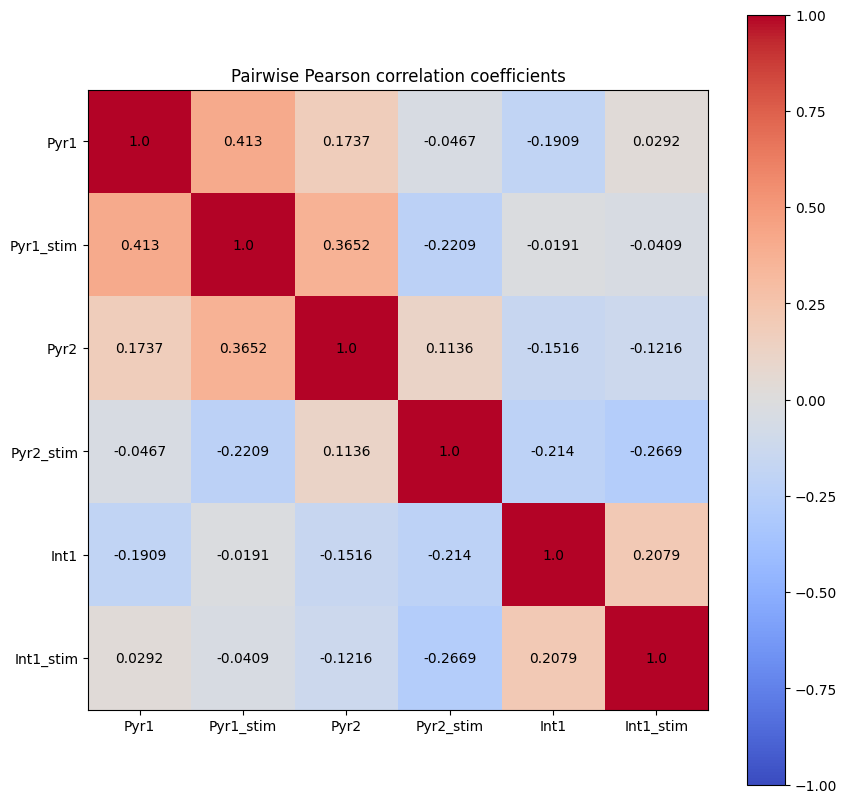

In [56]:
# We bin the spikes in both cell and stim spikes
allspikes = [SpikeTrain(np.array(x) / 1000 * pq.s, t_stop=sim_tstop * pq.ms) for x in spike_trains]
binned_spikes = BinnedSpikeTrain(allspikes, bin_size=10 * pq.ms)  # 10 ms bin
# Correlation coefficient matrix between all spike trains
cc = elstc.corrcoef(binned_spikes)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cc, cmap="coolwarm", vmin=-1.0, vmax=1.0, origin="upper")

# We want to show all ticks...
ax.set_xticks(np.arange(len(name_lst)))
ax.set_yticks(np.arange(len(name_lst)))
# ... and label them with the respective list entries
ax.set_xticklabels(name_lst)
ax.set_yticklabels(name_lst)

# Loop over data dimensions and create text annotations.
for i in range(len(name_lst)):
    for j in range(len(name_lst)):
        text = ax.text(
            j, i, np.round(cc[i, j], 4), ha="center", va="center", color="black"
        )

ax.set_title("Pairwise Pearson correlation coefficients")
plt.colorbar(im)
plt.show()